In [25]:
import os
# os.chdir('../')

In [26]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from models.loader import load_model
from client import Client
from datasets.dataloader import load_global_dataset, create_clustered_dataset
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
train, test = load_global_dataset('cifar10')
datasets = create_clustered_dataset(train, 2, 'rotation')
dataset1_train, dataset2_train = datasets

val_size = len(dataset1_train) // 10
train_size = len(dataset1_train) - val_size
train_dataset1, val_dataset1 = torch.utils.data.random_split(dataset1_train, [train_size, val_size])
train_dataset2, val_dataset2 = torch.utils.data.random_split(dataset2_train, [train_size, val_size])

dataset2_sub1_train = Subset(train_dataset2, range(len(train_dataset2)//2))
dataset2_sub1_val = Subset(val_dataset2, range(len(val_dataset2)//2))
dataset2_sub2_train = Subset(train_dataset2, range(len(train_dataset2)//2, len(train_dataset2)))
dataset2_sub2_val = Subset(val_dataset2, range(len(val_dataset2)//2, len(val_dataset2)))

client1_train_loader = DataLoader(train_dataset1, batch_size=32, shuffle=True)
client1_val_loader = DataLoader(val_dataset1, batch_size=32, shuffle=False)
client2_train_loader = DataLoader(dataset2_sub1_train, batch_size=32, shuffle=True) 
client2_val_loader = DataLoader(dataset2_sub1_val, batch_size=32, shuffle=False)
client3_train_loader = DataLoader(dataset2_sub2_train, batch_size=32, shuffle=True)
client3_val_loader = DataLoader(dataset2_sub2_val, batch_size=32, shuffle=False)

print('Client 1:', len(client1_train_loader), len(client1_val_loader))
print('Client 2:', len(client2_train_loader), len(client2_val_loader))
print('Client 3:', len(client3_train_loader), len(client3_val_loader))

Files already downloaded and verified
Files already downloaded and verified


ValueError: too many values to unpack (expected 2)

In [27]:
def permute_linear_neurons(seq, layer_indices):
    
    permuted_seq = deepcopy(seq)
    layer1 = permuted_seq[layer_indices[0]]
    layer2 = permuted_seq[layer_indices[1]]

    # reorder the hidden neurons from layer1 to layer2
    layer1_weight = layer1.weight
    layer1_bias = layer1.bias
    layer2_weight = layer2.weight
    layer2_bias = layer2.bias

    perm =  torch.randperm(layer1_weight.size(0))
    layer1_weight = layer1_weight[perm]
    layer2_weight = layer2_weight[:,perm]

    permuted_seq[layer_indices[0]].weight.data = layer1_weight
    permuted_seq[layer_indices[0]].bias.data = layer1_bias
    permuted_seq[layer_indices[1]].weight.data = layer2_weight
    permuted_seq[layer_indices[1]].bias.data = layer2_bias

    return permuted_seq



In [28]:
model = load_model('cifar10cnn')

In [29]:
client = Client(id=0, device=torch.device('cpu'), cluster_assignment=0)
# train the model on the client
criterion = nn.CrossEntropyLoss()
model1 = deepcopy(model)
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
model1 = client.train(deepcopy(model), train_loader, criterion, optimizer1, num_epochs=2)
model2 = deepcopy(model)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
model2 = client.train(deepcopy(model), train_loader, criterion, optimizer2, num_epochs=2)

acc, loss = client.evaluate(model1, val_loader, criterion)

# Example: Permuting only the Linear layer at index 4 (the last layer in the model)
layer_indicies = [7,9]

# Permute the parameters in the model
permuted_seq = permute_linear_neurons(model1.nn, layer_indicies)
permuted_model = deepcopy(model1)
permuted_model.nn = permuted_seq

perm_acc, perm_loss = client.evaluate(permuted_model, val_loader, criterion)
print(f'Original model accuracy: {acc}, loss: {loss}')
print(f'Permuted model accuracy: {perm_acc}, loss: {perm_loss}')

# assert acc and loss of unpermuted model is approx. equal to permuted model
assert abs(acc - perm_acc) < 0.0001
assert abs(loss - perm_loss) < 0.0001



Client 0 initialized on device:  cpu


AttributeError: 'NoneType' object has no attribute 'parameters'

In [ ]:
def shuffle_conv_filters(filters):
    perm = torch.randperm(filters.size(0))
    return filters[perm]
def noise_conv_filters(filters, noise_level=0.05):
    noise = torch.randn(filters.size()) * noise_level
    return filters + noise

client1_conv1 = model1.nn[0].weight
client2_conv1 = shuffle_conv_filters(client1_conv1)
client2_conv1 = noise_conv_filters(client1_conv1)

client3_conv1 = model2.nn[0].weight


assert client1_conv1.shape == client2_conv1.shape == client3_conv1.shape

(torch.Size([16, 3, 5, 5]), torch.Size([16, 3, 5, 5]))

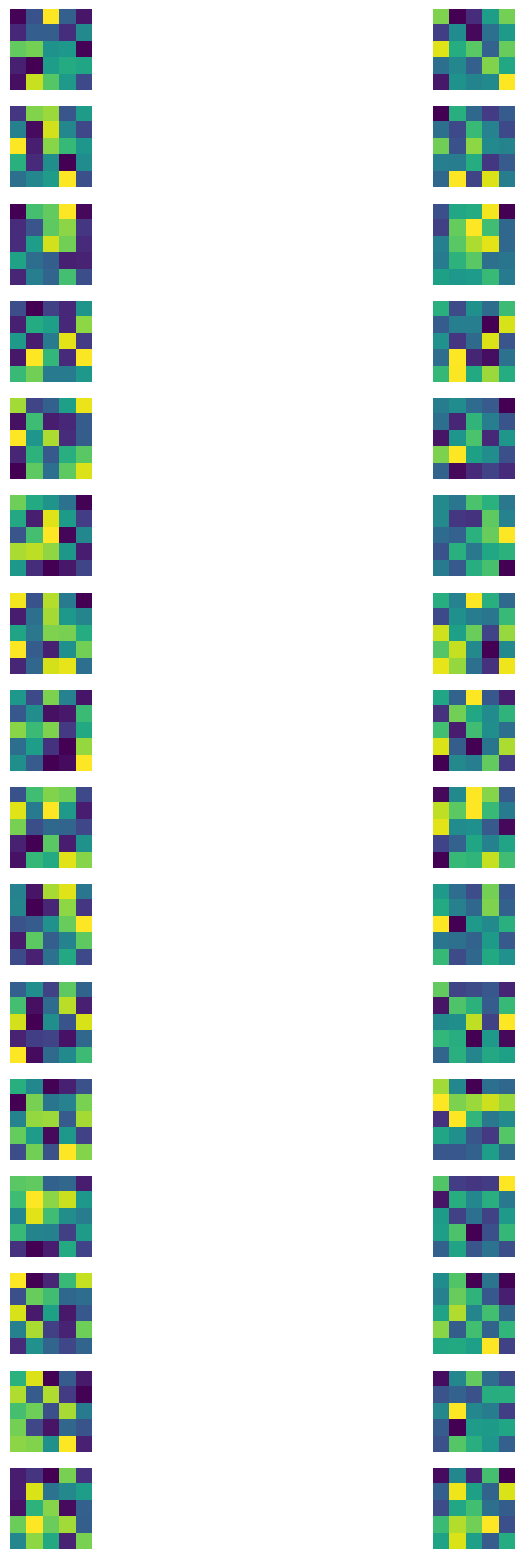

In [ ]:
# for each client, populate a set with the conv filters
client1_filters = set([cfilter for cfilter in client1_conv1])
client2_filters = set([cfilter for cfilter in client2_conv1])
# plot filters
fig, axs = plt.subplots(len(client2_filters), 2, figsize=(10, 20))
for i, (filter1, filter2) in enumerate(zip(client1_filters, client2_filters)):
    axs[i, 0].imshow(filter1[0].detach().numpy())
    axs[i, 1].imshow(filter2[0].detach().numpy())
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
plt.show()



In [ ]:
def filter_dist(filter1, filter2):
    return torch.dist(filter1, filter2,p=1)
def filter_match(filter1, filter2, threshold=0.1):
    return filter_dist(filter1, filter2) < threshold

# for each filter in client1, find the closest filter in client2
filter_matches = []
removed = {}
for filter1 in client1_filters:
    min_dist = float('inf')
    closest_filter = None
    for filter2 in client2_filters:
        if filter2 in removed:
            continue
        dist = filter_dist(filter1, filter2)
        if dist < min_dist:
            min_dist = dist
            closest_filter = filter2
    filter_matches.append((filter1, closest_filter, min_dist))
    removed.add(filter2)

In [ ]:
from operator import itemgetter
sorted_dists = sorted(filter_matches,key=itemgetter(2))
largest_dist = sorted_dists[-1][2]


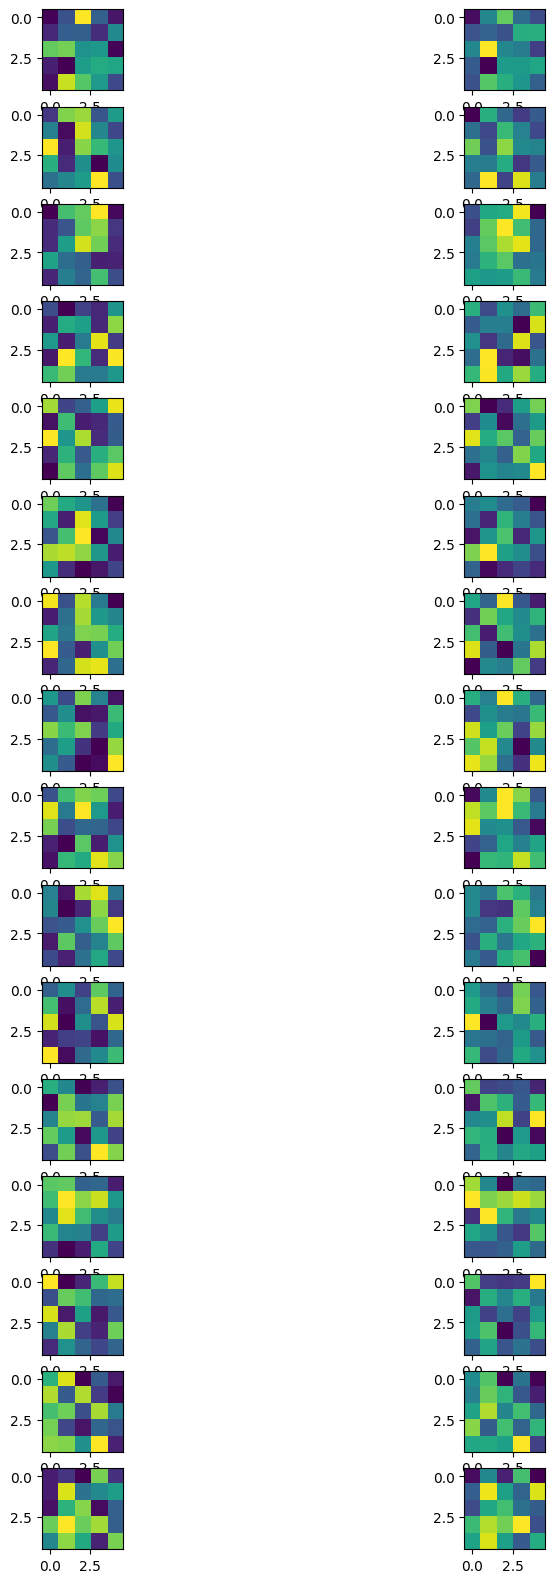

In [ ]:
# plot the filter matches

fig, axs = plt.subplots(len(filter_matches), 2, figsize=(10, 20))
for i, (filter1, filter2) in enumerate(filter_matches):
    axs[i, 0].imshow(filter1.detach().numpy()[0])
    axs[i, 1].imshow(filter2.detach().numpy()[0])
plt.show()

